Here is a notebook demonstrating very minimal processing of encoder data  
This approximates what is being done by VBA and the AllenSDK, but simplifies in two ways:
* No attempt is made to scale velocity to true units of linear or angular speed
* Encoder 'wraps', where the output value crosses its max value (from ~5V to 0V or vice-versa) are not corrected  

The periodic 'noise' is visible even with this minimal processing.  
Importantly, there is no periodicity in the $\Delta$time signal, indicating that time intervals are not being sampled in the same irregular manner as the voltage signals.  

Doug Ollerenshaw  
7/15/2020

## Minimal imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Here is a path to an example PKL file. This is behavior_session 974807143, acquired on 10/31/19 on CAM2P.5

In [3]:
pkl_path = '/allen/programs/braintv/production/visualbehavior/prod3/specimen_925234058/behavior_session_974807143/974659900.pkl'

## Load the data with Pandas

In [4]:
data = pd.read_pickle(pkl_path)

## Create a dataframe with times and voltages extracted directly from the file (no processing yet)

In [5]:
running_df = pd.DataFrame({
    'dt':np.hstack((np.nan,data['items']['behavior']['intervalsms']))/1000,
    'time':np.hstack((0,np.cumsum(data['items']['behavior']['intervalsms'])))/1000,
    'v_in':data['items']['behavior']['encoders'][0]['vin'],
    'v_sig':data['items']['behavior']['encoders'][0]['vsig'],
})
running_df.head()

,dt,time,v_in,v_sig
0,NaN,0.000000,4.990407,0.616515
1,0.016695,0.016695,5.004600,0.682317
2,0.016826,0.033520,5.003310,0.701670
3,0.016456,0.049977,4.991698,0.745538
4,0.016699,0.066676,5.003310,0.791987


## Calculate derivatives

In [6]:
running_df['v_sig_diff'] = running_df['v_sig'].diff()
running_df['dvdt'] = running_df['v_sig_diff']/running_df['dt']
running_df.head()

,dt,time,v_in,v_sig,v_sig_diff,dvdt
0,NaN,0.000000,4.990407,0.616515,NaN,NaN
1,0.016695,0.016695,5.004600,0.682317,0.065802,3.941448
2,0.016826,0.033520,5.003310,0.701670,0.019354,1.150239
3,0.016456,0.049977,4.991698,0.745538,0.043868,2.665705
4,0.016699,0.066676,5.003310,0.791987,0.046448,2.781516


## Plot
The units on the y-axis will be `V\s` which could be converted to either `rad\s`, `deg\s` or `cm\s` using the appropriate linear scaling factor. But I'm ignoring that here.

Note the big range, this is due to the huge derivatives at the 'wraps'  

<IPython.core.display.Javascript object>


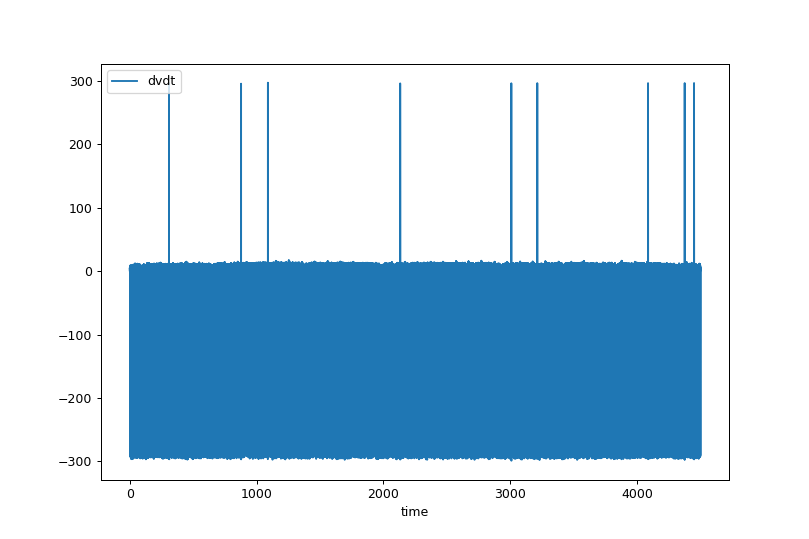

In [7]:
fig,ax = plt.subplots(figsize=(9,6))
running_df.plot(
    x='time',
    y='dvdt',
    ax=ax
)

## Zoom in to look closer

<IPython.core.display.Javascript object>


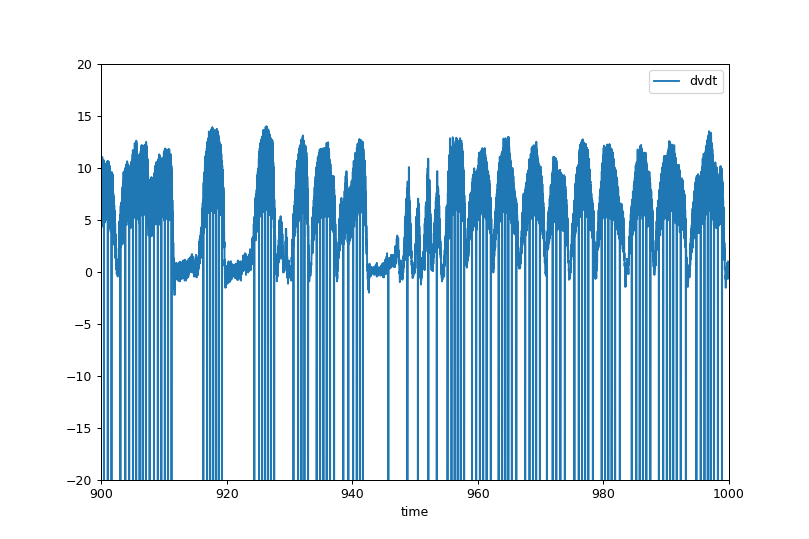

(-20.0, 20.0)

In [8]:
fig,ax = plt.subplots(figsize=(9,6))
running_df.plot(
    x='time',
    y='dvdt',
    ax=ax
)
ax.set_xlim(900,1000)
ax.set_ylim(-20,20)

## Clip out the 'wraps' for simplicity. I'm just ignoring them for now by setting them to NAN

In [9]:
def clip(v,lower_limit,upper_limit):
    if v <= lower_limit:
        return np.nan
    elif v >= upper_limit:
        return np.nan
    else:
        return v
running_df['dvdt_clipped'] = running_df['dvdt'].map(lambda dvdt:clip(dvdt,-20,20))

## Plot again without the wraps

<IPython.core.display.Javascript object>


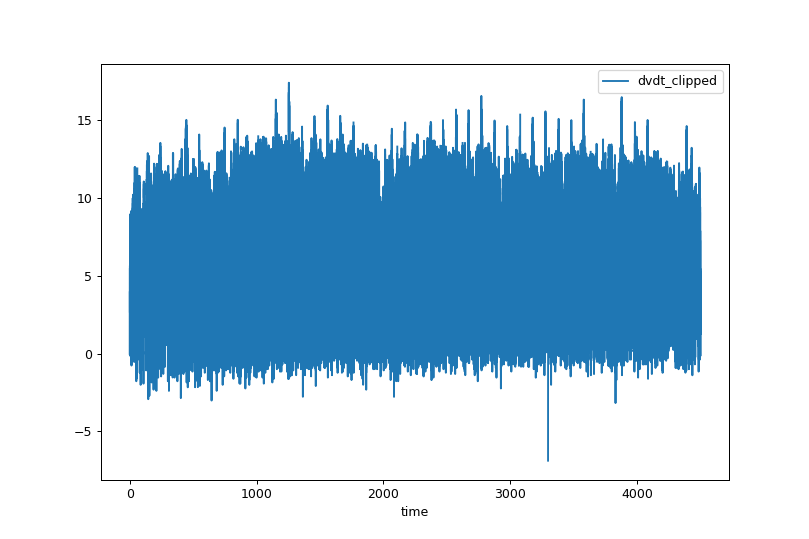

In [10]:
fig,ax = plt.subplots(figsize=(9,6))
running_df.plot(
    x='time',
    y='dvdt_clipped',
    ax=ax
)

## and zoom in
There is clearly still a big noise envelope around the dvdt signal

<IPython.core.display.Javascript object>


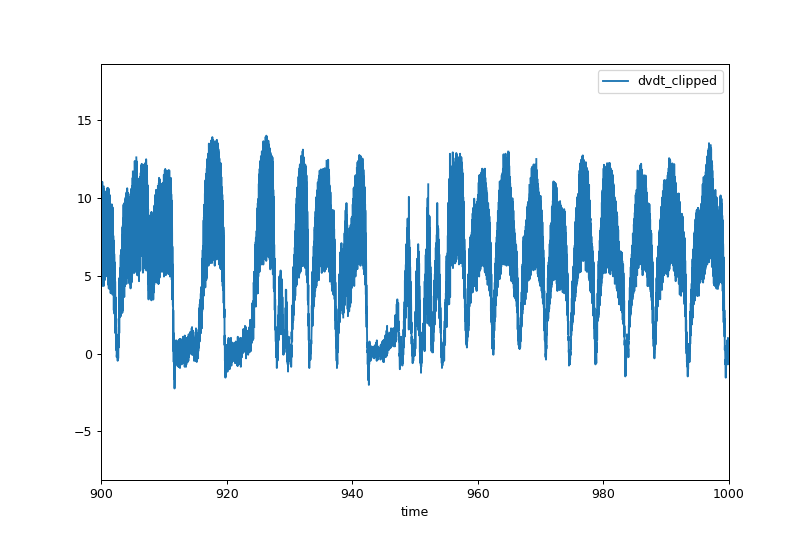

(900.0, 1000.0)

In [11]:
fig,ax = plt.subplots(figsize=(9,6))
running_df.plot(
    x='time',
    y='dvdt_clipped',
    ax=ax
)
ax.set_xlim(900,1000)

## clip out the `wraps` from the raw v_sig_diff signal for visualization purposes

In [12]:
running_df['v_sig_diff_clipped'] = running_df['v_sig_diff']
running_df['v_sig_diff_clipped'].loc[running_df.index[pd.isnull(running_df['dvdt_clipped'])]] = np.nan

## Now plot `dt`, `dv` and `dv\dt` all on the same time scale

This demonstrates that the time signal does not oscillate in the same way that dv does. Thus, the oscillatory noise in `dv\dt` comes entirely from oscillation in the `dv` signal, not from incorrect application of $\Delta$time

fig,ax=plt.subplots(3,1,figsize=(9,9),sharex=True)
running_df.plot(
    x='time',
    y='dt',
    ax=ax[0]
)
running_df.plot(
    x='time',
    y='v_sig_diff_clipped',
    ax=ax[1]
)
running_df.plot(
    x='time',
    y='dvdt_clipped',
    ax=ax[2]
)

## zoom in to demonstrate more clearly

<IPython.core.display.Javascript object>


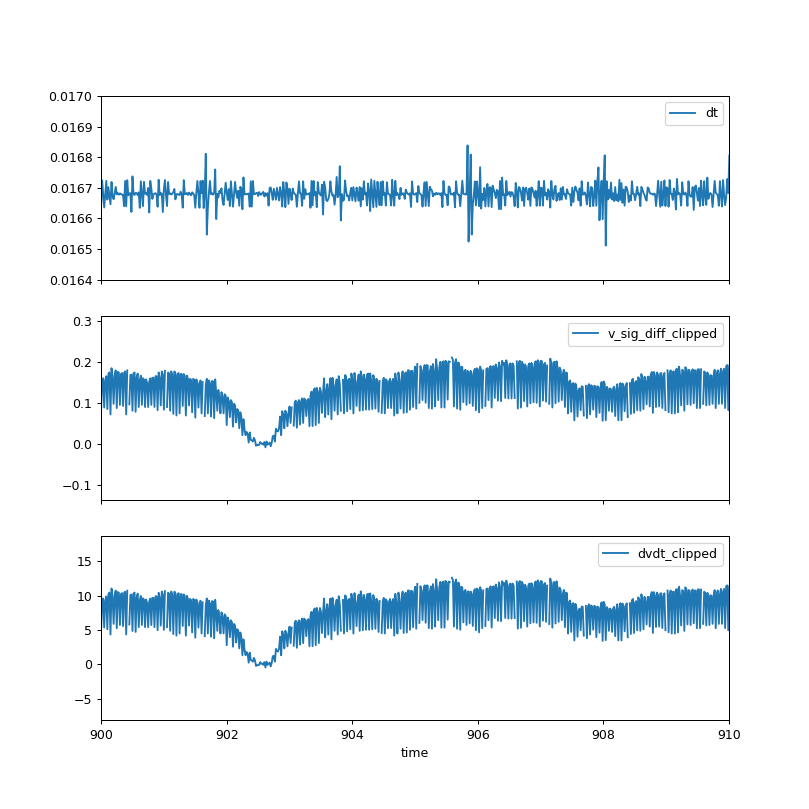

(0.0164, 0.017)

In [13]:
fig,ax=plt.subplots(3,1,figsize=(9,9),sharex=True)
running_df.plot(
    x='time',
    y='dt',
    ax=ax[0]
)
running_df.plot(
    x='time',
    y='v_sig_diff_clipped',
    ax=ax[1]
)
running_df.plot(
    x='time',
    y='dvdt_clipped',
    ax=ax[2]
)
ax[0].set_xlim(900,910)
ax[0].set_ylim(0.0164,0.017)

In [14]:
data.keys()

dict_keys(['comp_id', 'unpickleable', 'items', 'start_time', 'script', 'rig_id', 'threads', 'stop_time', 'session_uuid', 'platform_info'])

In [16]:
data['items']['behavior'].keys()

dict_keys(['ai', 'trial_count', 'ao', 'lick_sensors', 'rewards_dispensed', 'volume_dispensed', 'encoders', 'behavior_path', 'config_path', 'auto_update', 'trial_log', 'window', 'params', 'config', 'rewards', 'unpickleable', 'nidaq_tasks', 'intervalsms', 'behavior_text', 'update_count', 'omitted_flash_frame_log', 'custom_output_path', 'items', 'stimuli', 'cl_params', 'sync_pulse'])

In [31]:
data['items']['behavior']['trial_log']

[{'index': 0,
  'cumulative_rewards': 0,
  'cumulative_volume': 0.0,
  'stimulus_changes': [],
  'success': False,
  'licks': [(306.71420667888043, 18039)],
  'trial_params': {'catch': False, 'auto_reward': True, 'change_time': 4},
  'rewards': [],
  'events': [['trial_start', '', 305.8083515555012, 17985],
   ['initial_blank', 'enter', 305.8083936854264, 17985],
   ['initial_blank', 'exit', 305.8084407890233, 17985],
   ['pre_change', 'enter', 305.80846068371017, 17985],
   ['pre_change', 'exit', 305.8084758972943, 17985],
   ['stimulus_window', 'enter', 305.8085516726458, 17985],
   ['early_response', '', 306.7143359943452, 18039],
   ['abort', '', 306.7143863162003, 18039],
   ['timeout', 'enter', 306.7144340049351, 18039],
   ['timeout', 'exit', 307.02579346155267, 18058],
   ['trial_end', '', 307.0258282772547, 18058]]},
 {'index': 1,
  'cumulative_rewards': 0,
  'cumulative_volume': 0.0,
  'stimulus_changes': [],
  'success': False,
  'licks': [(310.1842037356371, 18247), (310.30

In [34]:
data.keys()

dict_keys(['comp_id', 'unpickleable', 'items', 'start_time', 'script', 'rig_id', 'threads', 'stop_time', 'session_uuid', 'platform_info'])

In [36]:
print(data['start_time'])

2019-10-31 11:26:52.132000
